In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
def readFileAsArr(fileName, source):
    res = []
    file = open('./data/100ms/' + fileName, encoding="utf8").read()
    for ind, line in enumerate(file.split('\n')):
        if ind < 100:
            continue
        if line == '':
            continue
        splitLine = line.split(",")
        res.append([source, splitLine[0], splitLine[1], float(splitLine[2])])
    return res

latencies = readFileAsArr('plumber.txt', 'Plumber')
latencies = latencies + readFileAsArr('baseline.txt', 'Baseline')
latencies = latencies + readFileAsArr('dapr.txt', 'Dapr')

In [11]:
df = pd.DataFrame(latencies, columns=['Platform', 'Begin nano', 'End nano', 'Latency (ms)'])

In [12]:
df.groupby(["Platform"]).describe()


Latency (ms)                                                    \
                count      mean       std       min       25%       50%   
Platform                                                                  
Baseline      10436.0  2.537011  4.404079  1.585248  2.150949  2.316635   
Dapr          10436.0  2.811304  4.447768  1.780162  2.395728  2.574313   
Plumber       10436.0  3.009134  5.052892  1.896680  2.558203  2.726625   

                                
               75%         max  
Platform                        
Baseline  2.501281  338.513705  
Dapr      2.776509  338.587615  
Plumber   2.934326  339.116577

In [13]:
df.head()

,Platform,Begin nano,End nano,Latency (ms)
0,Plumber,1630055816324017379,1630055816326649721,2.632342
1,Plumber,1630055816425055254,1630055816427789602,2.734348
2,Plumber,1630055816526000199,1630055816528568661,2.568462
3,Plumber,1630055816626830561,1630055816629534285,2.703724
4,Plumber,1630055816727875716,1630055816730917158,3.041442


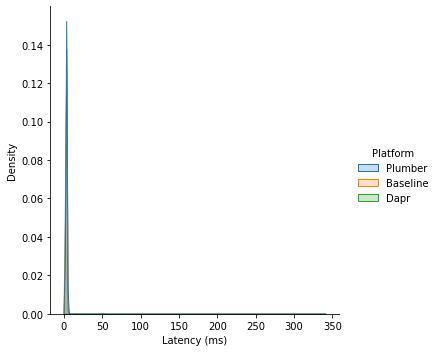

In [14]:
sns.displot(df, x="Latency (ms)", hue="Platform", kind="kde", fill=True)

In [15]:
df.describe()

,Latency (ms)
count,31308.000000
mean,2.785816
std,4.648245
min,1.585248
25%,2.335184
50%,2.548874
75%,2.772690
max,339.116577


<AxesSubplot:xlabel='Platform', ylabel='Latency (ms)'>

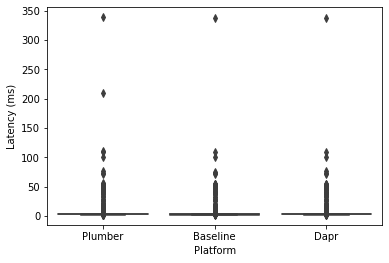

In [16]:
sns.boxplot(data=df, x="Platform", y="Latency (ms)")

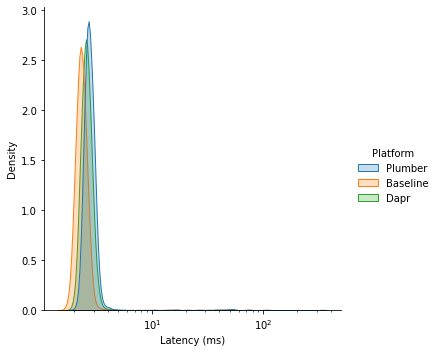

In [17]:
sns.displot(df, x="Latency (ms)", hue="Platform", kind="kde", fill=True, log_scale=True)

<AxesSubplot:xlabel='Latency (ms)', ylabel='Proportion'>

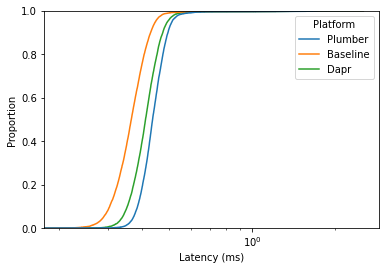

In [18]:
sns.ecdfplot(data=df, x="Latency (ms)", hue="Platform", log_scale=True)

In [19]:
df.shape

(31308, 4)

In [20]:
# Obvious issue with outliers for visualizations: remove them through IQR method
plat_dfs = []
for plat in df["Platform"].unique():
    print(plat)
    df_plat = df[df["Platform"] == plat]
    q1 = df_plat.quantile(0.25)["Latency (ms)"]
    q3 = df_plat.quantile(0.75)["Latency (ms)"]
    iqr = q3 - q1
    print(df_plat.shape)
    df_plat = df_plat[~((df["Latency (ms)"] < (q1 - 1.5 * iqr)) | (df["Latency (ms)"] > (q3 + 1.5 * iqr)))].reset_index(drop=True)
    print(df_plat.shape)
    plat_dfs.append(df_plat)

filtered_df = pd.concat(plat_dfs)


Plumber
(10436, 4)
(10229, 4)
Baseline
(10436, 4)
(10281, 4)
Dapr
(10436, 4)
(10243, 4)


<ipython-input-20-cb4ad0cf4b78>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plat = df_plat[~((df["Latency (ms)"] < (q1 - 1.5 * iqr)) | (df["Latency (ms)"] > (q3 + 1.5 * iqr)))].reset_index(drop=True)
<ipython-input-20-cb4ad0cf4b78>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plat = df_plat[~((df["Latency (ms)"] < (q1 - 1.5 * iqr)) | (df["Latency (ms)"] > (q3 + 1.5 * iqr)))].reset_index(drop=True)
<ipython-input-20-cb4ad0cf4b78>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plat = df_plat[~((df["Latency (ms)"] < (q1 - 1.5 * iqr)) | (df["Latency (ms)"] > (q3 + 1.5 * iqr)))].reset_index(drop=True)


In [21]:
filtered_df.groupby(["Platform"]).describe()

Latency (ms)                                                    \
                count      mean       std       min       25%       50%   
Platform                                                                  
Baseline      10281.0  2.326162  0.245677  1.625808  2.148204  2.311008   
Dapr          10243.0  2.585940  0.266245  1.867550  2.391593  2.568492   
Plumber       10229.0  2.742516  0.258257  2.031876  2.554902  2.719901   

                              
               75%       max  
Platform                      
Baseline  2.491628  3.026375  
Dapr      2.762238  3.347370  
Plumber   2.920478  3.495572

In [22]:
# preprocessing for catplot
df_metrics = pd.DataFrame(columns=["Metric", "Platform", "Latency (ms)"])
for plat in df["Platform"].unique():
    plat_df = df[df["Platform"] == plat]
    df_metrics = df_metrics.append({"Metric": "Median", "Platform": plat, "Latency (ms)": plat_df.quantile(0.5)["Latency (ms)"]}, ignore_index=True) 
    df_metrics = df_metrics.append({"Metric": "90th Percentile", "Platform": plat, "Latency (ms)": plat_df.quantile(0.9)["Latency (ms)"]}, ignore_index=True) 
    df_metrics = df_metrics.append({"Metric": "99th Percentile", "Platform": plat, "Latency (ms)": plat_df.quantile(0.99)["Latency (ms)"]}, ignore_index=True) 

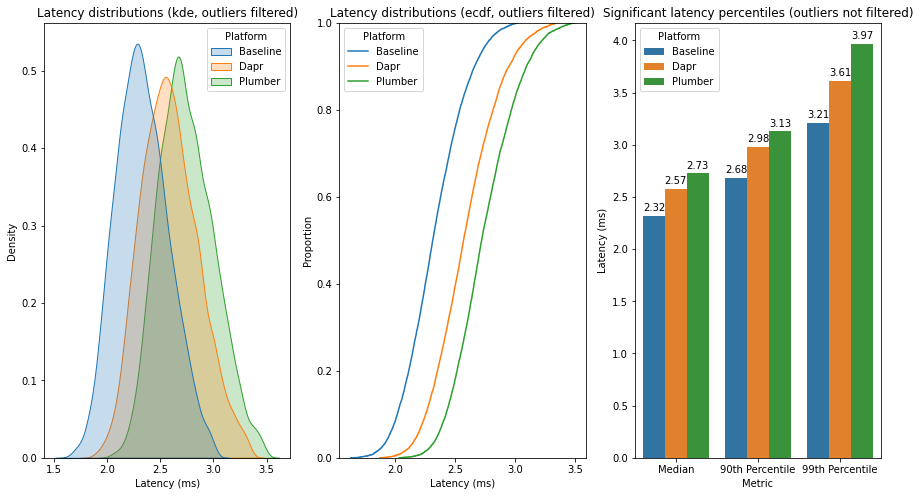

In [23]:

f, axes = plt.subplots(1, 3, figsize=(15,8))
h_order = ["Baseline", "Dapr", "Plumber"]
sns.kdeplot(data=filtered_df, x="Latency (ms)", hue="Platform", fill=True, ax=axes[0], hue_order=h_order)
sns.ecdfplot(data=filtered_df, x="Latency (ms)", hue="Platform", ax=axes[1], hue_order=h_order)
sns.barplot(
    data=df_metrics,
    x="Metric", y="Latency (ms)", hue="Platform",
    hue_order=h_order,
    ax = axes[2]
)

axes[0].title.set_text('Latency distributions (kde, outliers filtered)')
axes[1].title.set_text('Latency distributions (ecdf, outliers filtered)')
axes[2].title.set_text('Significant latency percentiles (outliers not filtered)')


def add_value_labels(ax, spacing=3):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(axes[2])

plt.savefig("vis-latency-distrs.png")


In [24]:
df = df.astype({'Begin nano': 'int64'})
delta_s = (df["Begin nano"].max() - df["Begin nano"].min()) / 1_000_000_000
tot_messages = len(df.index) / 3
tot_messages / delta_s

9.880078976150187

In [25]:
df.groupby(["Platform"]).sem()

,Begin nano,Latency (ms)
Platform,,
Baseline,2.985701e+09,0.043111
Dapr,2.985701e+09,0.043539
Plumber,2.985701e+09,0.049462


In [36]:
df.groupby(["Platform"]).quantile(0.9995)

,Begin nano,Latency (ms)
Platform,,
Baseline,1.630057e+18,67.555576
Dapr,1.630057e+18,67.738376
Plumber,1.630057e+18,75.468818


In [29]:
outliers = df[(df["Latency (ms)"] > 5)]
# filter the 99.99th percentile outliers as they ruin the later visualization
outliers = outliers[outliers["Latency (ms)"] < 100]


In [30]:
outliers.groupby("Platform").describe()

Begin nano                                                          \
              count          mean           std           min           25%   
Platform                                                                      
Baseline       46.0  1.630056e+18  2.823606e+11  1.630056e+18  1.630056e+18   
Dapr           56.0  1.630056e+18  2.854218e+11  1.630056e+18  1.630056e+18   
Plumber        56.0  1.630056e+18  2.860777e+11  1.630056e+18  1.630056e+18   

                                                   Latency (ms)             \
                   50%           75%           max        count       mean   
Platform                                                                     
Baseline  1.630056e+18  1.630056e+18  1.630057e+18         46.0  35.970203   
Dapr      1.630056e+18  1.630057e+18  1.630057e+18         56.0  32.472148   
Plumber   1.630056e+18  1.630057e+18  1.630057e+18         56.0  34.419963   

                                                                           
                std       min        25%        50%        75%        max  
Platform                                                                   
Baseline  18.745891  6.062016  16.706975  38.483281  51.170367  75.170847  
Dapr      19.996973  5.100514  14.263616  34.985560  50.028954  76.085546  
Plumber   19.694978  5.005412  16.100556  37.690863  50.942270  75.892214

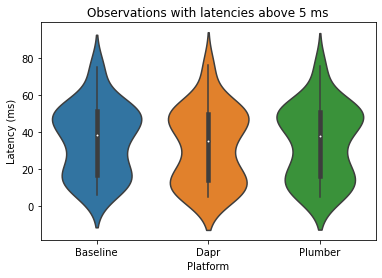

In [37]:
ax = sns.violinplot(x="Platform", y="Latency (ms)", data=outliers, order=["Baseline", "Dapr", "Plumber"])
ax.title.set_text('Observations with latencies above 5 ms')
plt.savefig("vis-latency-outliers-100.png")